<a href="https://colab.research.google.com/github/JustinasLekavicius/VilniusUniversity/blob/main/DeepLearningLabTask1_JustinasLekavicius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Justinas Lekavičius, Deep Learning Lab Task 1
#Task Formulation
The first task will require developing: - 

*   [ X ] An efficient data reader with an optional pre-trained image classification 
*   [ X ]  Calculate accuracy, precision, reproduction f1 statistics for a selected 1000 images from OpenImages
*   [ X ]  Use at least 3 classes, select classes by yourself
*   [ X ] Implement threshold analysis, enabling the classification of images for each task class by changing T∈[0,1]. 
*   [ X ] The statistic will have to be recalculated after the threshold change. 
*   [ X ] As part of the reporting exercise, the tutor will send you test images with which you will have to demonstrate how your implemented model works. 

   The software solution is at your discretion. 
   Concepts (batch, Dataset, DataLoader, workers, pre-fetching, caching, parallelisation of data scanning, parallelisation of data transformations (augmentations)). 
 Note: use custom dataset, check sigmoid vs softmax activation functions, analyse threshold, calculate metrics. 

In [3]:
pip install openimages


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.6 MB/s eta 0:00:00


**Imports**

In [4]:
import os
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.color import gray2rgb
from skimage.transform import resize
import glob
import PIL
import matplotlib.pyplot as plt
from openimages.download import download_dataset
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**Samples, selected model and classes**

In [5]:

#--------------------------------------------------
samples = 1000
data_directory = "task1Data"

if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    
class_names = ["Laptop", "Desk", "Necklace"] # random classes to download
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

#Is GPU used?
!nvidia-smi

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Thu May 11 11:55:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading the class images

In [6]:
print("Downloading the class data...")
download_dataset(data_directory, class_names, limit=samples)

100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


{'laptop': {'images_dir': 'task1Data/laptop/images'},
 'desk': {'images_dir': 'task1Data/desk/images'},
 'necklace': {'images_dir': 'task1Data/necklace/images'}}

In [7]:
 weights.meta["categories"]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [8]:
def read_img(file_name):
    img = io.imread(file_name)
    if img.ndim == 2:
        img = gray2rgb(img)
    img = PIL.Image.fromarray(np.uint8(img)).convert('RGB')
    img = preprocess(img)
    # Add batch dimension
    img = img.unsqueeze(0)

    return img.float()

In [9]:
# creation of Custom dataset

class CustomDataset(Dataset):

    def __init__(self, images_dir, custom=False):
        self.images_dir = images_dir
        self.custom = custom
        if self.custom == False:
          self.class1_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[0].lower()))
          self.class2_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[1].lower()))
          self.class3_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[2].lower()))

          self.class1 = len(self.class1_files)
          self.class2 = len(self.class2_files)
          self.class3 = len(self.class3_files)
        
          self.files = self.class1_files + self.class2_files + self.class3_files

          self.labels = np.zeros(len(self.files))
          self.labels[:self.class1] = weights.meta["categories"].index(class_names[0].lower())
          self.labels[self.class1:self.class1+self.class2] = weights.meta["categories"].index(class_names[1].lower())
          self.labels[self.class1+self.class2:] = weights.meta["categories"].index(class_names[2].lower())

          self.order =  [x for x in np.random.permutation(len(self.labels))]
          self.files = [self.files[x] for x in self.order]
          self.labels = [self.labels[x] for x in self.order]
        if self.custom == True:
          self.files = glob.glob(self.images_dir + "/*.jpg")

    def __len__(self):
        if self.custom == False:
          return (len(self.labels))
        if self.custom == True:
          return (len(self.files))

    def __getitem__(self, i):

        files = self.files[i]
        im = read_img(files)[0]
        img = np.array(im.numpy())
        if self.custom == False:
          y = self.labels[i]
          return (img, y)
        if self.custom == True:
          return img

dataset = CustomDataset(data_directory)

Using GPU if it's available and transfering model to it

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device);


Showing some images to see that they're read correctly

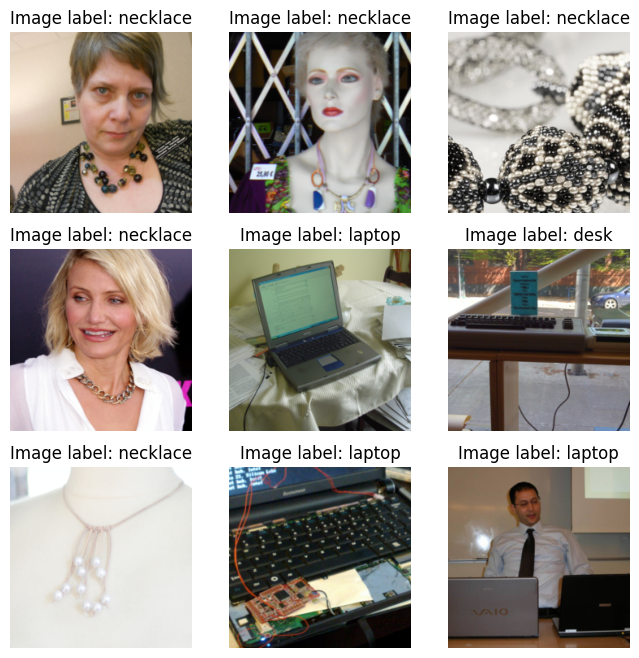

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = torch.tensor(img)
    image_label = weights.meta["categories"][int(label)]
    figure.add_subplot(rows, cols, i, title=f"Image label: {image_label}")
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Setting batch size, DataLoader and model to eval mode.


In [12]:
batch_size=32
dataset_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def get_confusion_matrix(y_true, y_pred):
    conf = np.zeros((len(class_names), len(class_names)))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

def get_roc_curve(true, pred, delta=0.1):
    best_f1score = 0
    best_flscore_threshold = 0

    thresholds = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(pred.shape)
    for th in thresholds:
        y_pred[pred < th] = 0
        y_pred[pred >= th] = 1

        TN, FP, FN, TP = confusion_matrix(true, y_pred).ravel()
        
        TPR = TP / (TP + FN)  
        FPR = FP / (FP + TN) 
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1score = 2 * (recall * precision) / (recall + precision)
        if f1score > best_f1score:
          best_f1score = f1score
          best_f1score_threshold = th
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, best_f1score, best_f1score_threshold, thresholds

Predictions function (sigmoid).



In [14]:

def predictions_metrics():
  predicted_labels = []
  true_labels = []
  images_to_display = 3
  with torch.inference_mode():
    image_number = 0
    for batch_idx, (data, label) in enumerate(dataset_dataloader):
         print("Working with batch ", batch_idx+1, " out of ", len(dataset_dataloader), " ( batch size: ", batch_size, ")")
         data = data.to(device)
         label = label.to(device)
         output = model(data).squeeze(0).sigmoid()
         _, pred = torch.max(output, 1)
         predicted_labels.extend(pred.cpu().numpy())
         true_labels.extend(label.cpu().numpy())

         if image_number < images_to_display:
           fig = plt.figure(figsize=(8,10))
           ax = plt.subplot(images_to_display, 1, 1)
           pred_label = weights.meta["categories"][int(pred[0])]
           image_label = weights.meta["categories"][int(label[0])]
           ax.set_title(f"Predicted: {pred_label}, actual: {image_label}")
           img = torch.tensor(data.cpu())
           im = img[0].squeeze().numpy().transpose((1, 2, 0))
           mean = np.array([0.485, 0.456, 0.406])
           std = np.array([0.229, 0.224, 0.225])
           im = std * im + mean
           im = np.clip(im, 0, 1)
           plt.axis("off")
           plt.imshow(im, cmap="gray")
           image_number += 1

  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3

  c_predicted = np.array(predicted_labels)
  c_true = np.array(true_labels)

  #Setting labels – class 1 as 0, class 2 as 1, class 3 as 2, and all other classes as 3.

  c_predicted[np.where(c_predicted==weights.meta["categories"].index(class_names[0].lower()))]=0
  c_predicted[np.where(c_predicted==weights.meta["categories"].index(class_names[1].lower()))]=1
  c_predicted[np.where(c_predicted==weights.meta["categories"].index(class_names[2].lower()))]=2

  for i in range(len(c_predicted)):
      if c_predicted[i] not in [0, 1, 2]:
          c_predicted[i] = 3

  c_true[np.where(c_true==weights.meta["categories"].index(class_names[0].lower()))]=0
  c_true[np.where(c_true==weights.meta["categories"].index(class_names[1].lower()))]=1                    
  c_true[np.where(c_true==weights.meta["categories"].index(class_names[2].lower()))]=2

  for i in range(len(c_true)):
      if c_true[i] not in [0, 1, 2]:
          c_true[i] = 3 

  print(classification_report(c_true, c_predicted, target_names=[class_names[0], class_names[1],class_names[2], "Other"]))

  cm = confusion_matrix(c_true, c_predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = [class_names[0], class_names[1],class_names[2], "Other"])
  disp.plot()
  plt.show()
 

In [15]:
best_thresholds = [0,0,0]
best_f1scores   = [0,0,0]
def predictions_threshold_analysis():
  predicted_labels = []
  true_labels = []
  with torch.inference_mode():
        for batch_idx, (data, label) in enumerate(dataset_dataloader):
            print("Working with batch ", batch_idx+1, " out of ", len(dataset_dataloader), " ( batch size: ", batch_size, ")")
            data = data.to(device)
            label = label.to(device)
            output = model(data).squeeze(0).sigmoid()
            preds = output.cpu().numpy()
            for i in preds:
              predicted_classes = np.array([i[weights.meta["categories"].index(class_names[0].lower())],
                                      i[weights.meta["categories"].index(class_names[1].lower())],
                                      i[weights.meta["categories"].index(class_names[2].lower())]])
              predicted_labels.append(predicted_classes)
            true_labels.extend(label.cpu().numpy())

  threshold_delta = 0.001
  c_predicted = np.array(predicted_labels)

  c_true = np.array(true_labels)

  c_true[np.where(c_true==weights.meta["categories"].index(class_names[0].lower()))]=0
  c_true[np.where(c_true==weights.meta["categories"].index(class_names[1].lower()))]=1                    
  c_true[np.where(c_true==weights.meta["categories"].index(class_names[2].lower()))]=2

  for c in enumerate(class_names):
    class_index = c[0]
    class_name = c[1]
    c_true_class = (c_true == class_index).astype(int)
    c_predicted = np.array(predicted_labels)
    c_predicted = c_predicted[:,class_index].reshape((c_predicted.shape[0],))
    FPRs, TPRs, best_f1scores[class_index], best_thresholds[class_index], _ = get_roc_curve(c_true_class, c_predicted, threshold_delta)
    print("___________________________________________________________________________")
    print("Threshold analysis for class ", class_name, " – best f1score is ", best_f1scores[class_index], " with ", best_thresholds[class_index], " threshold")
    print("___________________________________________________________________________")

    # Plot the ROC curve
    plt.plot(FPRs, TPRs, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for class {class_name} (threshold delta = {threshold_delta})')
    plt.legend(loc="lower right")
    plt.show()

  

Working with batch  1  out of  94  ( batch size:  32 )
Working with batch  2  out of  94  ( batch size:  32 )
Working with batch  3  out of  94  ( batch size:  32 )
Working with batch  4  out of  94  ( batch size:  32 )
Working with batch  5  out of  94  ( batch size:  32 )
Working with batch  6  out of  94  ( batch size:  32 )
Working with batch  7  out of  94  ( batch size:  32 )
Working with batch  8  out of  94  ( batch size:  32 )
Working with batch  9  out of  94  ( batch size:  32 )
Working with batch  10  out of  94  ( batch size:  32 )
Working with batch  11  out of  94  ( batch size:  32 )
Working with batch  12  out of  94  ( batch size:  32 )
Working with batch  13  out of  94  ( batch size:  32 )
Working with batch  14  out of  94  ( batch size:  32 )
Working with batch  15  out of  94  ( batch size:  32 )
Working with batch  16  out of  94  ( batch size:  32 )
Working with batch  17  out of  94  ( batch size:  32 )
Working with batch  18  out of  94  ( batch size:  32 )
W

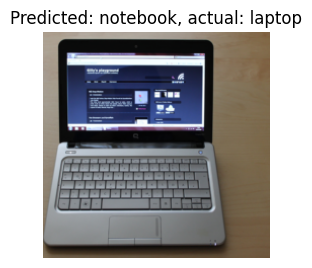

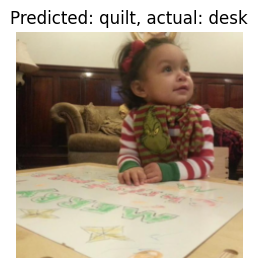

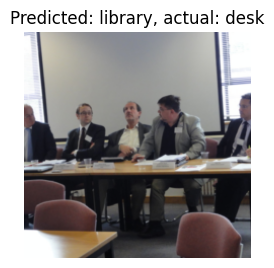

<Figure size 800x800 with 0 Axes>

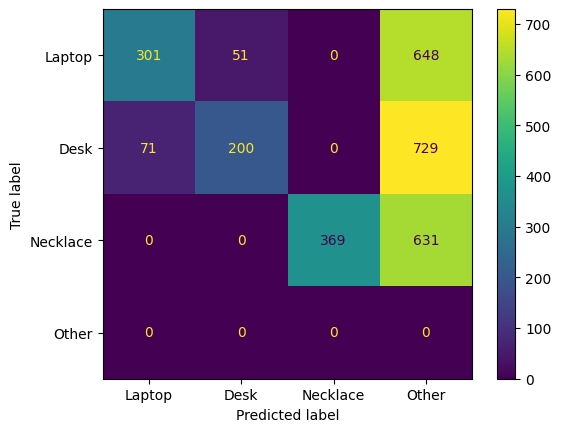

In [16]:
predictions_metrics()

Working with batch  1  out of  94  ( batch size:  32 )
Working with batch  2  out of  94  ( batch size:  32 )
Working with batch  3  out of  94  ( batch size:  32 )
Working with batch  4  out of  94  ( batch size:  32 )
Working with batch  5  out of  94  ( batch size:  32 )
Working with batch  6  out of  94  ( batch size:  32 )
Working with batch  7  out of  94  ( batch size:  32 )
Working with batch  8  out of  94  ( batch size:  32 )
Working with batch  9  out of  94  ( batch size:  32 )
Working with batch  10  out of  94  ( batch size:  32 )
Working with batch  11  out of  94  ( batch size:  32 )
Working with batch  12  out of  94  ( batch size:  32 )
Working with batch  13  out of  94  ( batch size:  32 )
Working with batch  14  out of  94  ( batch size:  32 )
Working with batch  15  out of  94  ( batch size:  32 )
Working with batch  16  out of  94  ( batch size:  32 )
Working with batch  17  out of  94  ( batch size:  32 )
Working with batch  18  out of  94  ( batch size:  32 )
W

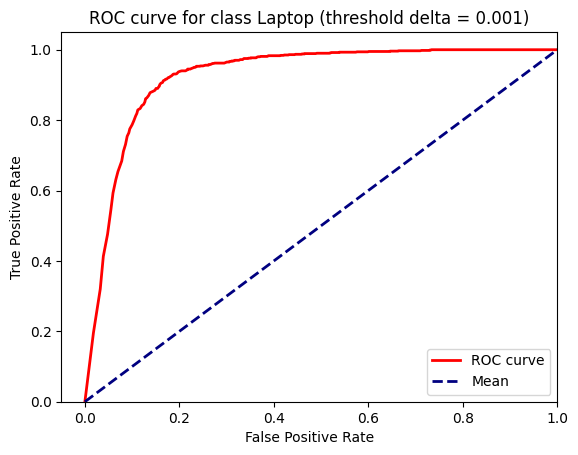

___________________________________________________________________________
Threshold analysis for class  Desk  – best f1score is  0.6717990275526742  with  0.869  threshold
___________________________________________________________________________


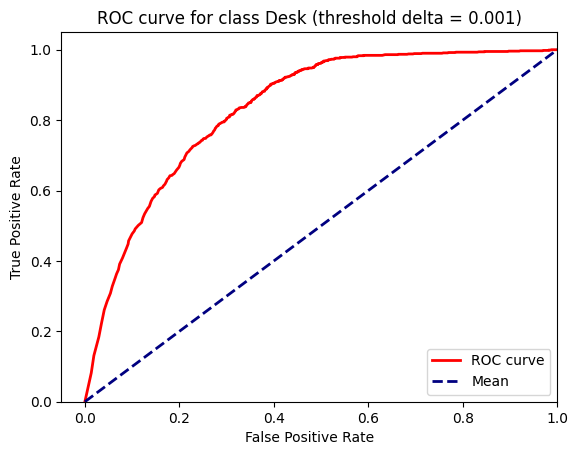

___________________________________________________________________________
Threshold analysis for class  Necklace  – best f1score is  0.9422084623323015  with  0.648  threshold
___________________________________________________________________________


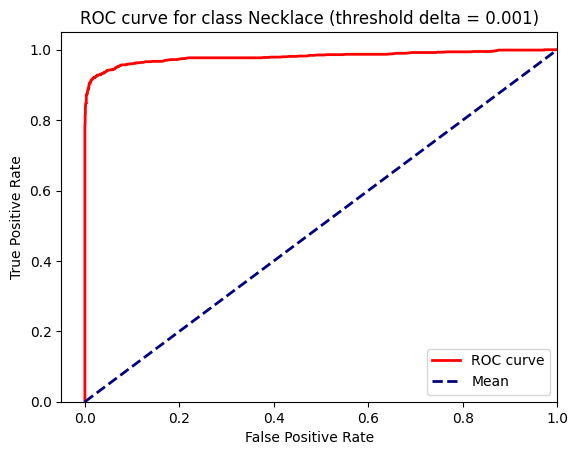

In [17]:
predictions_threshold_analysis()

Best thresholds and f1scores for each class (laptop, desk and necklace respectively)

In [18]:
print(best_thresholds)
print(best_f1scores)

[0.972, 0.869, 0.648]
[0.8152274837511606, 0.6717990275526742, 0.9422084623323015]


Model predictions for custom images (put images in task1CustomData folder.). Optimised with best thresholds for each class.

Scenarios covered:
*   One class in image
*   Two classes in image
*   No classes in image



Working with picture  1  out of  4
[0.55117935 0.29503104 0.600567  ]
[0. 0. 0.]
Working with picture  2  out of  4
[0.4923048  0.52608025 0.6466868 ]
[0. 0. 0.]
Working with picture  3  out of  4
[0.9880343  0.98465246 0.44901934]
[1. 1. 0.]
Working with picture  4  out of  4
[0.64916813 0.9828955  0.38909334]
[0. 1. 0.]


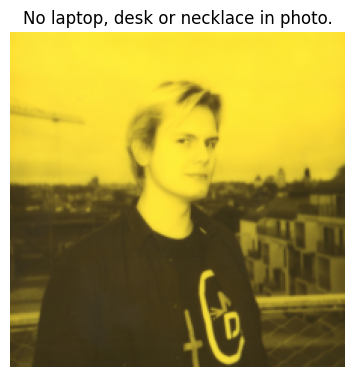

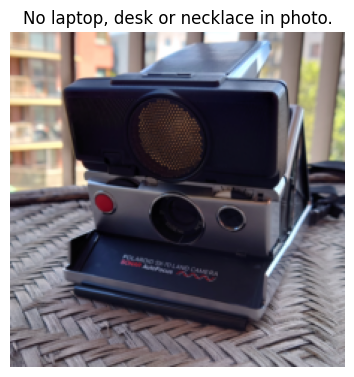

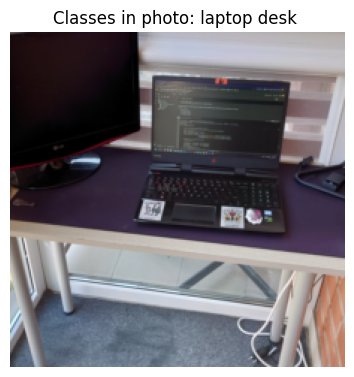

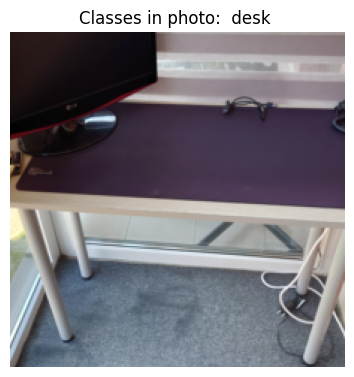

In [56]:
custom_data_directory = "task1CustomData"

custom_dataset = CustomDataset(custom_data_directory, custom=True)
custom_dataset_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=1, shuffle=False, num_workers=2)
predicted_labels_custom = []
model.eval()
with torch.inference_mode():
  
    for i, data in enumerate(custom_dataset_dataloader):
        print("Working with picture ", i+1, " out of ", len(custom_dataset_dataloader))
        data = data.to(device)
        output = model(data).squeeze(0).sigmoid()
        preds = output.cpu().numpy()
        predicted_classes = np.array([preds[weights.meta["categories"].index(class_names[0].lower())],
                                      preds[weights.meta["categories"].index(class_names[1].lower())],
                                      preds[weights.meta["categories"].index(class_names[2].lower())]])

        c_predicted = np.array(predicted_classes)
        print(c_predicted)

        c_predicted[0] = c_predicted[0] > best_thresholds[0]
        c_predicted[1] = c_predicted[1] > best_thresholds[1]
        c_predicted[2] = c_predicted[2] > best_thresholds[2]
        print(c_predicted)
        fig = plt.figure(figsize=(25,20))
        ax = plt.subplot(len(custom_dataset_dataloader), 3, i+1)
        img = torch.tensor(data.cpu())
        im = img.squeeze().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        im = np.clip(im, 0, 1)
        plt.axis("off")
        if not any(c_predicted):
          ax.set_title("No laptop, desk or necklace in photo.")
        if any(c_predicted):
          ax.set_title("Classes in photo: {} {} {}".format("laptop" if c_predicted[0] else "", "desk" if c_predicted[1] else "", "necklace" if c_predicted[2] else ""))
        plt.imshow(im, cmap="gray")